<a href="https://colab.research.google.com/github/bob8dod/NLP_SelfStudying/blob/main/Attention_mechanism.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 양방향 LSTM과 어텐션 메커니즘(BiLSTM with Attention mechanism)

### IMDB 리뷰 데이터


In [ ]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
vocab_size = 10000
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words = vocab_size)

17465344/17464789 [==============================] - 1s 0us/step


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:155: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

In [ ]:
print('리뷰의 최대 길이 : {}'.format(max(len(l) for l in X_train)))
print('리뷰의 평균 길이 : {}'.format(sum(map(len, X_train))/len(X_train)))

리뷰의 최대 길이 : 2494
리뷰의 평균 길이 : 238.71364


In [ ]:
max_len = 500 #평균길이보다 약 2배 길게 패딩 진행
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

### 바다나우 어텐션(Bahdanau Attention)

바다나우 어텐션은 아래와 같은 어텐션 스코어 함수를 사용  
이 어텐션 스코어 함수를 사용하여 어텐션 메커니즘을 구현하면 됨


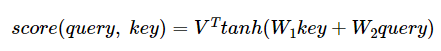



이 어텐션 메커니즘을 사용하는 이유?  
RNN의 마지막 은닉 상태는 예측을 위해 사용됨. 그런데 이 RNN의 마지막 은닉 상태는 몇 가지 유용한 정보들을 손실한 상태입니다. 그래서 RNN이 time step을 지나며 손실했던 정보들을 다시 참고  
=>  RNN의 모든 은닉 상태들을 다시 한 번 참고하겠다는 것

In [ ]:
import tensorflow as tf

In [ ]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = Dense(units)
    self.W2 = Dense(units)
    self.V = Dense(1)

  def call(self, values, query): # 단, key와 value는 같음
    # query shape == (batch_size, hidden size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden size)
    # score 계산을 위해 뒤에서 할 덧셈을 위해서 차원을 변경해줍니다.
    hidden_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # self.V 에 score을 적용할것이기 때문에 1차원 덧붙임
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(values) + self.W2(hidden_with_time_axis)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

### 양방향 LSTM + 어텐션 메커니즘(BiLSTM with Attention Mechanism)

In [ ]:
from tensorflow.keras.layers import Dense, Embedding, Bidirectional, LSTM, Concatenate, Dropout
from tensorflow.keras import Input, Model
from tensorflow.keras import optimizers
import os

In [ ]:
# 입력층과 임베딩층 설계
sequence_input = Input(shape=(max_len,), dtype='int32')
embedded_sequences = Embedding(vocab_size, 128, input_length=max_len, mask_zero = True)(sequence_input)

# 양방향 LSTM 첫번째 층
lstm = Bidirectional(LSTM(64, dropout=0.5, return_sequences = True))(embedded_sequences)
# 두번째 층을 위에 쌓을 예정이므로 return_sequences를 True
# 양방향 LSTM 두번째 층
lstm, forward_h, forward_c, backward_h, backward_c = Bidirectional(LSTM(64, dropout=0.5, return_sequences=True, return_state=True))(lstm)
# 상태를 리턴받아야 하므로 return_state를 True

In [ ]:
print(lstm.shape, forward_h.shape, forward_c.shape, backward_h.shape, backward_c.shape)

(None, 500, 128) (None, 64) (None, 64) (None, 64) (None, 64)


각 은닉 상태나 셀 상태의 경우에는 64차원을 가지는데, lstm의 경우에는 (500 × 128)의 크기를 가짐  
=>foward 방향과 backward 방향이 연결된 hidden state벡터가 모든 시점에 대해서 존재함을 의미

양방향 LSTM의 은닉 상태와 셀 상태를 사용하려면 두 방향의 LSTM의 상태들을 연결(concatenate)해주면 됨

In [ ]:
state_h = Concatenate()([forward_h, backward_h]) # 은닉 상태
state_c = Concatenate()([forward_c, backward_c]) # 셀 상태

In [ ]:
# 은닉 상태를 사용하여 이를 입력으로 컨텍스트 벡터(context vector)를 얻기
attention = BahdanauAttention(64) # 가중치 크기 정의
context_vector, attention_weights = attention(lstm, state_h)

컨텍스트 벡터를 밀집층(dense layer)에 통과시키고, 이진 분류이므로 최종 출력층에 1개의 뉴런을 배치하고, 활성화 함수로 시그모이드 함수를 사용

In [ ]:
dense1 = Dense(20, activation="relu")(context_vector)
dropout = Dropout(0.5)(dense1)
output = Dense(1, activation="sigmoid")(dropout)
model = Model(inputs=sequence_input, outputs=output)

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs = 3, batch_size = 256, validation_data=(X_test, y_test), verbose=1)

Epoch 1/3
38/98 [==========>...................] - ETA: 6:13 - loss: 0.6535 - accuracy: 0.6219

In [ ]:
print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test, y_test)[1]))